こんにちは、らんそうるい（[@rnsr0371](https://twitter.com/rnsr0371)）です。この記事では、バスケのデータ分析をやってみたい！　という人向けに、一緒にコード（Python）を書きながら、バスケのデータ分析を行ってみます。テーマは選手の成長を可視化しよう！　です。想定している読者は次のような感じです。
- Pythonの基礎的な文法が分かる（for文が登場します）
- Jupyter Notebookを導入済み
- バスケに限らず、データ分析が初めて  

分析に用いたコードはGitHub上にアップされています。

## 選手の成長をどう評価するか？
選手の成長という概念は複雑かつ抽象的で、その全てをデータから捉えることは難しいです。そこで、この記事では2020-21シーズンと2019-20シーズンのスタッツの差をとって、成長の指標としたいと思います。  
次の問題は、どのスタッツを使うかです。後述するrintaromasuda様のデータでは、EFFという選手の貢献度を表す指標が記録されているので、これを使うことにします。EFFの定義は次のとおりです。$$EFF＝(得点+リバウンド+アシスト+スティール)-(フィールドゴール失敗数+フリースロー失敗数+ターンオーバー)$$右辺の前半の括弧の中はポジティブなスタッツを、後半の括弧の中はネガティブなスタッツを表しています。これらの差分がEFFです。  
この記事では、選手の評価を反映するスタッツとしてEFFを用いますが、EFFはオールインワンスタッツとしては原始的です。もっと効果的に選手の評価を反映させたい場合にはPIPMなどの高度なオールインワンスタッツを使ってみるとよいと思います。  
EFFはスタッツに残る貢献を（ある程度）反映していますが、スタッツに残らない貢献というのも気になるところです。スタッツに残らない貢献を評価するために、ここでは出場時間を使いたいと思います。出場時間はヘッドコーチの裁量によって決まります。出場時間が長いほど、ヘッドコーチからの評価が高いと考えられます。そして、その評価にはオフェンスだけではなく、ディフェンスからの視点も含まれていることが期待できます。また、オフェンス面からも、オフボールの動きやスペーシング、スクリーンプレーの上手さなどの視点が含まれていることでしょう。  
以上の考えから、2020-21シーズンと2019-20シーズンのEFFの差と出場時間の差を算出して、これらを選手の成長の指標としたいと思います。

## データを用意しよう！
データ分析するためにはデータが必要です。[rintaromasuda様のGitHub](https://github.com/rintaromasuda/bleaguer/tree/master/inst/extdata)から、teams.csvとgames_boxscore201920.csv、games_boxscore202021.csvをダウンロードして、これらを生データとして使いたいと思います。

## 分析しよう
### データの整形
では、必要なライブラリをインポートします。pandasとmatplotlibを使います。pandasをインポートすると、データフレーム型というとても都合の良いデータ型を扱えるようになります。matplotlibは可視化用のライブラリです。

In [106]:
#必要なライブラリのインポート
import pandas as pd
import matplotlib.pyplot as plt

次に、先程ダウンロードした.csvファイルをインポートします。（）内の書き方は「相対パス」「絶対パス」などで検索していただければ分かると思います。

In [107]:
#データのインポート
teams=pd.read_csv("data/teams.csv")
boxscore2019=pd.read_csv("data/games_boxscore_201920.csv")
boxscore2020=pd.read_csv("data/games_boxscore_202021.csv")

teamsから2019-20シーズン、2020-21シーズンのB1のデータだけを抽出していきます。抽出して得られたデータをboxscoreにマージして、それぞれのシーズンのB1のデータだけを抜き取ります。

In [108]:
#teamsから2019-20シーズンのB1のデータだけ抽出
teams2019=teams[teams["Season"]=="2019-20"]
teams2019=teams2019[teams2019["League"]=="B1"]

In [109]:
#teamsから2020-21シーズンのB1のデータだけ抽出
teams2020=teams[teams["Season"]=="2020-21"]
teams2020=teams2020[teams2020["League"]=="B1"]

In [110]:
#boxscore2019からB1のデータだけを取り出す
boxscore2019=teams2019.merge(boxscore2019,on="TeamId")

In [111]:
#boxscore2020からB1のデータだけを取り出す
boxscore2020=teams2020.merge(boxscore2020,on="TeamId")

選手ごとに平均スタッツを算出します。

In [112]:
#選手ごとに平均スタッツを算出する
boxscore2019=boxscore2019.groupby("Player").mean()
boxscore2020=boxscore2020.groupby("Player").mean()

2019-20シーズンのデータと2020-21シーズンのデータを結合します。suffixesという引数（ひきすう）は、単にPTSとだけ書いてあると、2019-20シーズンのPTSなのか2020-21シーズンのPTSなのかが分からなくなるため、区別するためにお尻につける目印を指定するものです。

In [113]:
#boxscore2019とboxscore2020を選手名で結合する
data=boxscore2019.merge(boxscore2020,on="Player",suffixes=["_2019","_2020"])

In [118]:
#インデックスをリセットする
data=data.reset_index()

forループを使って、EFFと出場時間の差分をとります。eff_diffという空のリストを用意して、そこにappendメソッドで一つずつデータを加えていきます。最後に、dataにEFF_diffという名前で列に追加します。出場時間の場合も同様です。

In [119]:
#EFFの2019と2020の差分をとる
eff_diff=[]
for eff_2019,eff_2020 in zip(data["EFF_2019"],data["EFF_2020"]):
    eff_diff.append(eff_2020-eff_2019)
    
data["EFF_diff"]=pd.DataFrame(eff_diff)

In [120]:
#出場時間の2019と2020の差分をとる
min_diff=[]
for min_2019,min_2020 in zip(data["MIN_2019"],data["MIN_2020"]):
    min_diff.append(min_2020-min_2019)
    
data["MIN_diff"]=pd.DataFrame(min_diff)

データを扱いやすくするために、必要な列だけを残して、他を捨てます。

In [121]:
data

,Player,TeamId_2019,ScheduleKey_2019,PlayerId_2019,Number_2019,MIN_2019,PTS_2019,FGM_2019,FGA_2019,F3GM_2019,...,TO_2020,ST_2020,BS_2020,BSR_2020,F_2020,FD_2020,DUNK_2020,EFF_2020,EFF_diff,MIN_diff
0,アイラ・ブラウン,700.0,4408.857143,8452.0,33.0,31.090000,12.738095,4.976190,10.714286,0.976190,...,1.796296,1.259259,0.962963,0.370370,2.296296,3.629630,0.0,18.611111,2.968254,0.720185
1,アキ・チェンバース,694.0,4383.365854,8448.0,10.0,30.786341,10.536585,3.853659,9.390244,1.170732,...,1.076923,0.730769,0.076923,0.192308,1.730769,1.230769,0.0,8.038462,-3.839587,-5.649418
2,アレックス・カーク,706.0,4393.250000,12582.0,53.0,31.654722,17.583333,6.583333,11.388889,0.305556,...,0.914286,0.571429,1.000000,0.285714,1.742857,4.314286,0.0,24.971429,1.776984,-2.805865
3,ウィリアムスニカ,693.0,4378.150000,9345.0,28.0,16.727000,8.250000,3.225000,5.575000,0.000000,...,2.083333,0.850000,0.550000,0.316667,2.850000,2.983333,0.0,13.266667,2.966667,5.828833
4,エドワード・モリス,694.0,4383.365854,9259.0,32.0,15.955366,3.756098,1.512195,3.609756,0.243902,...,0.522727,0.068182,0.295455,0.340909,0.931818,1.090909,0.0,4.363636,-1.758315,-4.219684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,頓宮裕人,720.0,4389.536585,10262.0,45.0,3.461951,0.878049,0.390244,1.048780,0.000000,...,0.152542,0.050847,0.203390,0.118644,1.271186,0.254237,0.0,0.135593,-0.571724,4.569913
196,飴谷由毅,696.0,4443.000000,30404.0,77.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.111111,0.166667,0.000000,0.055556,0.666667,0.388889,0.0,1.111111,1.111111,4.896667
197,高橋耕陽,698.0,4363.410256,10818.0,24.0,20.350769,7.846154,2.871795,7.974359,1.333333,...,0.672727,0.181818,0.018182,0.109091,0.690909,0.509091,0.0,2.000000,-3.333333,-11.358769
198,鵤誠司,703.0,4398.731707,8529.0,18.0,22.077561,6.073171,2.365854,6.170732,0.853659,...,0.965517,0.758621,0.189655,0.206897,1.810345,0.862069,0.0,4.931034,-0.971405,-0.662733


In [122]:
#必要な列だけ抽出する
data=data.loc[:,["Player","EFF_diff","MIN_diff"]]

In [123]:
#データの確認
data

,Player,EFF_diff,MIN_diff
0,アイラ・ブラウン,2.968254,0.720185
1,アキ・チェンバース,-3.839587,-5.649418
2,アレックス・カーク,1.776984,-2.805865
3,ウィリアムスニカ,2.966667,5.828833
4,エドワード・モリス,-1.758315,-4.219684
...,...,...,...
195,頓宮裕人,-0.571724,4.569913
196,飴谷由毅,1.111111,4.896667
197,高橋耕陽,-3.333333,-11.358769
198,鵤誠司,-0.971405,-0.662733


### 可視化しよう！
さて、EFFの差分と出場時間の差分が用意できたので、可視化してみましょう。2変数を同時に扱いたいので、散布図が適当だと思います。差分は0以上だと「成長している」と考えるので、分かりやすいように、EFFの差分（縦軸）と出場時間の差分（横軸）の値がそれぞれ０のところに直線を引きました。４分割されたエリアの内、右上にいる選手たちがEFFから見ても、出場時間から見ても、成長した選手だと言うことができます。

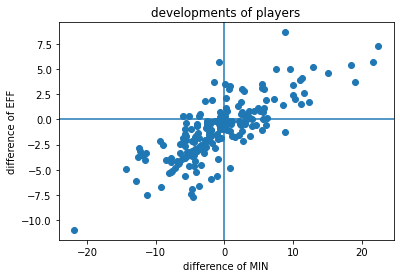

In [124]:
#可視化する
plt.plot(data["MIN_diff"],data["EFF_diff"],"o")
plt.ylabel("difference of EFF")
plt.xlabel("difference of MIN")
plt.title("developments of players")
plt.axhline(0)
plt.axvline(0)
plt.show()

右上のエリアにいる選手が具体的に誰なのか調べるために、EFFの差分と出場時間の差分で積をとって調べてみましょう。

In [125]:
#EFF_diffとMIN_diffの積をとって、散布図で右上にいる選手を探す
dev=[]
for eff_diff,min_diff in zip(data["EFF_diff"],data["MIN_diff"]):
    dev.append(eff_diff*min_diff)
    
data["Dev"]=pd.DataFrame(dev)

In [126]:
#Devが高い選手ベスト10を表示
#(EFF_diffをを0以上の選手の中から探すことで、マイナス掛けるマイナスで積が正になっている選手を取り除ける)
data[data["EFF_diff"]>=0].sort_values("Dev",ascending=False).head(10)

,Player,EFF_diff,MIN_diff,Dev
99,山口颯斗,7.222222,22.414815,161.884774
123,森川正明,5.663693,21.707618,122.945288
117,松脇圭志,5.400000,18.385667,99.282600
34,ニック・メイヨ,8.631818,8.822227,76.151862
118,林翔太郎,3.710210,18.974930,70.400979
77,大倉颯太,4.562500,15.055000,68.688437
112,晴山ケビン,5.175000,12.952893,67.031221
81,大浦颯太,4.954802,9.526073,47.199810
92,小酒部泰暉,4.110145,11.290217,46.404430
143,狩俣昌也,3.869915,11.002903,42.580300


Dev（EFFの差と出場時間の差の積）が大きい選手を大別すると、特別指定選手（山口選手、大倉選手、小酒部選手）、移籍組（森川選手、メイヨ選手、林選手、晴山選手）、その他（松脇選手、大浦選手、狩俣選手）になることが分かりました。特別指定選手と移籍組がEFFと出場時間を伸ばすというのは、直感に一致する結果だと思います。

## 終わりに
お付き合いいただきありがとうございました。この記事では、選手の成長を可視化しよう！　というテーマで分析を行いました。選手の成長を昨シーズンと比べたEFFの伸び・出場時間の伸びで評価し、これらのデータから散布図を描きました。EFFの伸びと出場時間の伸びの積が大きい選手（散布図上で右上のエリアにいる選手）を調べたところ、特別指定選手と移籍組の評価が高いということが分かりました。これは直感に一致する結果だと思います。  
選手の成長というのは複雑で抽象的な概念ですが、その一部分であれば、スタッツを利用して評価できることができる、というのが実感していただけると嬉しいです。もっと分析を深めたいという方は、EFFの代わりにPIPMなどのもっと進んだアドバンスドスタッツを用いるといった改善ができると思います。ぜひチャレンジしてみてください。　　